# Shooting Methods

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/shooting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

These methods use numerical optimizers to design trajectories.  We have to design cost and constraint functions that define the trajectories we want - the constraints to decide if an answer is acceptable and the cost to choose between answers.  For example, we might look for the shortest path that respects the limits of our vehicle.  In these examples we'll use curvature limits, which are somewhat represenative of a fixed-wing aircraft problem.  The particular method covered is _single shooting_ where the cost is found by integrating candidate decisions forward from the starting point.  There is also _multiple shooting_ where you design several trajectory segments and then try and stitch them together.

## Single Shooting

### Problem definition

We start by defining a start and goal pose.  These include heading angle as well as position.

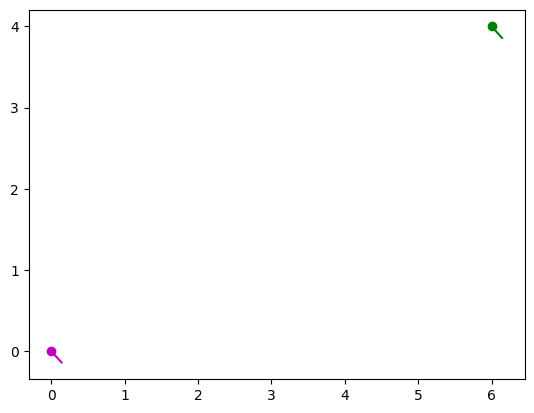

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import cos,sin

x0 = np.array([0,0,-np.pi/4.])
xG = np.array([6.,4.,-np.pi/4])


def plot_pose(x,col):
  # small length just for plotting
  d = np.array([0,0.2])
  # plot a dot with a pointing line
  plt.plot(x[0]+d*cos(x[2]),x[1]+d*sin(x[2]),col)
  plt.plot(x[0],x[1],col+'o')

plot_pose(x0,'m')
plot_pose(xG,'g')

plt.show()

### Dynamics model

Assuming the vehicle obeys a dynamic model of the form $\dot{x}=f(x,u)$, define the function $f$.

In [2]:
def f(x,u):
    return(np.array([u[0]*cos(x[2]),u[0]*sin(x[2]),u[0]*u[1]]))

Now, define a function that takes a sequence of time intervals and curvature commands, and integrates a path forward from the starting pose.

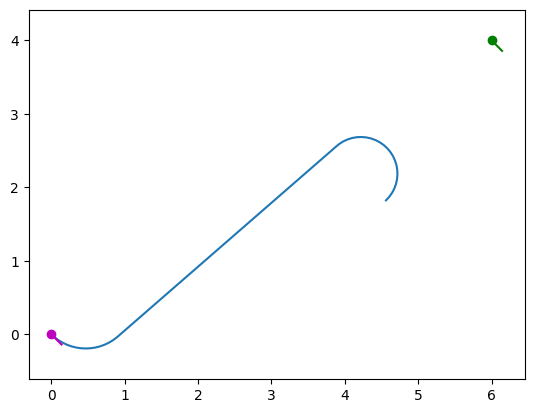

In [3]:
# define decision variable as vector of [time,curv,time,curv,time,curv]
# here: turn with curvature 1.2 for 1.5 seconds, than 0. (straight) for 3. seconds, and finally turn with curvature -1.2 for 1.5 seconds.
z = np.array([1.0,1.5,4.,0.,1.5,-2])

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def path(z,x0):
    # make sure it has even number of elements
    nz = len(z)
    assert(nz%2==0)
    # curvature values
    kv = z[range(1,nz,2)]
    # time intervals
    dv = z[range(0,nz,2)]
    # if given a negative time intervals, make it zero
    dv = [max(v,0) for v in dv]
    # now construct function to interpolate commands over time
    nv = len(kv)
    uv = np.vstack((np.ones((1,nv+1)),np.hstack((kv,0.))))
    tv = np.cumsum(np.append(0,dv))
    te=np.linspace(0.,max(tv),100)
    ut = interp1d(tv,uv,axis=1,kind='previous',bounds_error=False,fill_value='extrapolate')
    # use this to define the uncontrolled dynamics: x-dot=fc(x,t)
    def fc(t,x):
        u = ut(t)
        return(f(x,u))
    # and do the integration
    r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
    return(r.y)

p = path(z,x0)

plt.plot(p[0,:],p[1,:])
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()

OK, we have a path, but it gets nowhere near the goal yet as we haven't optimized anything.

Next, define a cost function that just adds up the three time variables.  In our example, since we're minimizing time of flight, that captures our need to minimize time.

In [4]:
def path_cost(z):
    total_time_flown = sum(z[0::2])
    return(total_time_flown)

# print value for the initial guess
print(path_cost(z))

6.5


Also define a bounds vector that tells the optimizer the range of each decision variable.  We limit each time variable to a range from 0.001 to 100 and each curvature to between +/-1.5

In [5]:
curvature_limit = 1.5
bounds = [(0.001,100.),(-curvature_limit,curvature_limit)]*int(len(z)/2)

Finally define a nonlinear constraint $f(z)$ such that $f(z)=0$ implies reaching our target pose.  We have to tell the optimizer that this is an _equality_ constraint, _i.e._ we require $f(z)=0$.

In [6]:
def endpoint_con_func(z):
    p = path(z,x0)
    return p[0:3,-1]-xG

constraints = [{'type':'eq',
                'fun':endpoint_con_func}]

Now we pass all the information that defines the problem - the cost, bounds and constraints - to the optimizer function.  In this case, we'll use the SLSQP solver built into `scipy`.  Fingers crossed...

In [7]:
from scipy.optimize import minimize
r = minimize(path_cost,z,method='SLSQP',bounds=bounds,constraints=constraints)
print(r)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.370867365776643
       x: [ 1.273e+00  1.395e+00  4.799e+00 -3.402e-02  2.299e+00
           -6.946e-01]
     nit: 43
     jac: [ 1.000e+00  0.000e+00  1.000e+00  0.000e+00  1.000e+00
            0.000e+00]
    nfev: 529
    njev: 43


That seemed to solve quite smoothly - plot the result, along with the initial guess for comparison.

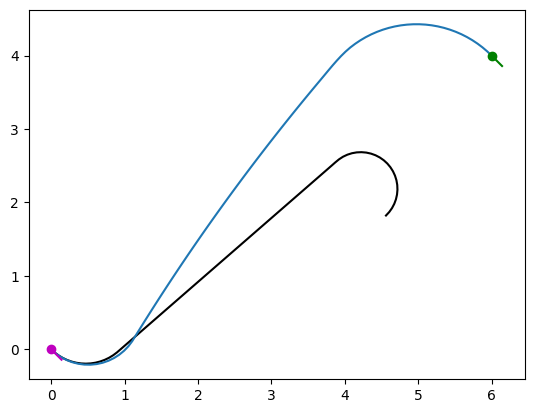

In [8]:
popt = path(r.x,x0)
plt.plot(p[0,:],p[1,:],'k')
plt.plot(popt[0,:],popt[1,:])
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()

Also plot the control time history for inspection.

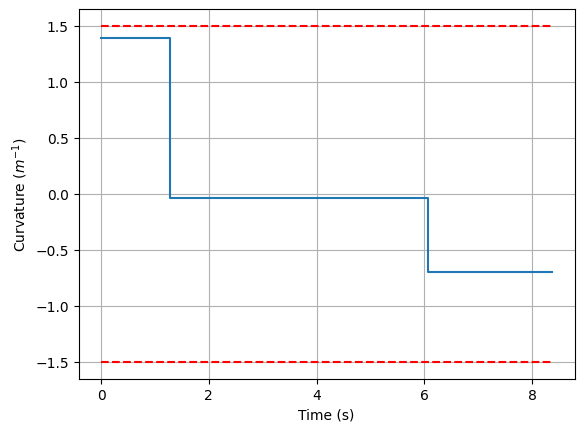

In [9]:
curvature_inputs = r.x[1::2]
time_durations = r.x[0::2]
time_breaks = [sum(time_durations[0:i]) for i in range(1+len(curvature_inputs))]
plt.plot(np.kron(time_breaks,[1,1])[1:-1],np.kron(curvature_inputs,[1,1]))
plt.plot([0,time_breaks[-1]],[curvature_limit,curvature_limit],'r--')
plt.plot([0,time_breaks[-1]],[-curvature_limit,-curvature_limit],'r--')
plt.grid('on')
plt.xlabel('Time (s)')
plt.ylabel('Curvature ($m^{-1}$)')
plt.show()

It's interesting to note that it's not using the full curvature limits.  Theory predicts the fastest solution here should be turn-straight-turn with the turns at the limit.  Further experiments (try changing `z` back where it was first defined) show that it's really sensitive to initial guess, sometimes not converging.  Clearly this approach has limitations.